<a href="https://colab.research.google.com/github/DimaKav/DS-Unit-4-Sprint-3-Neural-Networks/blob/master/module2-backpropagation/LS_DS_432_Backprop_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Backpropagation Practice

Implement a 3 input, 4 node hidden-layer, 1 output node Multilayer Perceptron on the following dataset:

| x1 | x2 | x3 | y |
|----|----|----|---|
| 0  | 0  | 1  | 0 |
| 0  | 1  | 1  | 1 |
| 1  | 0  | 1  | 1 |
| 0  | 1  | 0  | 1 |
| 1  | 0  | 0  | 1 |
| 1  | 1  | 1  | 0 |
| 0  | 0  | 0  | 0 |

If you look at the data you'll notice that the first two columns behave like an XOR gate while the last column is mostly just noise. Remember that creating an XOR gate was what the perceptron was criticized for not being able to learn. 

In [37]:
import numpy as np


X = np.array(([0,0,1],
              [0,1,1],
              [1,0,1],
              [0,1,0],
              [1,0,0],
              [1,1,1],
              [0,0,0]))

y = np.array(([0],[1],[1],[1],[1],[0],[0]))

y

array([[0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0]])

# Backprop without Gradient Descent

In [0]:
class Neural_Network(object):
  def __init__(self):
    self.inputs = 3
    self.hiddenNodes = 4
    self.outputNodes = 1

    # Initlize Weights
    self.L1_weights = np.random.randn(self.inputs, self.hiddenNodes) # (3x2)
    self.L2_weights = np.random.randn(self.hiddenNodes, self.outputNodes) # (3x1)

  def feed_forward(self, X):
    # Weighted sum between inputs and hidden layer
    self.hidden_sum = np.dot(X, self.L1_weights)
    # Activations of weighted sum
    self.activated_hidden = self.sigmoid(self.hidden_sum)
    # Weighted sum between hidden and output
    self.output_sum = np.dot(self.activated_hidden, self.L2_weights)
    # final activation of output
    self.activated_output = self.sigmoid(self.output_sum)
    return self.activated_output
    
  def sigmoid(self, s):
    return 1/(1+np.exp(-s))
  
  def sigmoidPrime(self, s):
    return s * (1 - s)
  
  def backward(self, X, y, o):
    # backward propgate through the network
    self.o_error = y - o # error in output
    self.o_delta = self.o_error*self.sigmoidPrime(o) # applying derivative of sigmoid to error

    self.z2_error = self.o_delta.dot(self.L2_weights.T) # z2 error: how much our hidden layer weights contributed to output error
    self.z2_delta = self.z2_error*self.sigmoidPrime(self.activated_hidden) # applying derivative of sigmoid to z2 error

    self.L1_weights += X.T.dot(self.z2_delta) # adjusting first set (input --> hidden) weights
    self.L2_weights += self.activated_hidden.T.dot(self.o_delta) # adjusting second set (hidden --> output) weights
    
  def train (self, X, y):
    o = self.feed_forward(X)
    self.backward(X, y, o)

In [39]:
NN = Neural_Network()
for i in range(1000): # trains the NN 1,000 times
  if i+1 in [1,2,3,4,5] or (i+1) % 50 == 0:
    print('+---------- EPOCH', i+1, '-----------+')
    print("Input: \n", X) 
    print("Actual Output: \n", y)  
    print("Predicted Output: \n" + str(NN.feed_forward(X))) 
    print("Loss: \n" + str(np.mean(np.square(y - NN.feed_forward(X))))) # mean sum squared loss
    print("\n")
  NN.train(X, y)

+---------- EPOCH 1 -----------+
Input: 
 [[0 0 1]
 [0 1 1]
 [1 0 1]
 [0 1 0]
 [1 0 0]
 [1 1 1]
 [0 0 0]]
Actual Output: 
 [[0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]]
Predicted Output: 
[[0.51634103]
 [0.56698157]
 [0.56923644]
 [0.75437159]
 [0.75121144]
 [0.62870169]
 [0.6888492 ]]
Loss: 
0.23309690827681934


+---------- EPOCH 2 -----------+
Input: 
 [[0 0 1]
 [0 1 1]
 [1 0 1]
 [0 1 0]
 [1 0 0]
 [1 1 1]
 [0 0 0]]
Actual Output: 
 [[0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]]
Predicted Output: 
[[0.50104865]
 [0.54704001]
 [0.55533425]
 [0.73568099]
 [0.73609144]
 [0.61090481]
 [0.67097009]]
Loss: 
0.23098113486669905


+---------- EPOCH 3 -----------+
Input: 
 [[0 0 1]
 [0 1 1]
 [1 0 1]
 [0 1 0]
 [1 0 0]
 [1 1 1]
 [0 0 0]]
Actual Output: 
 [[0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]]
Predicted Output: 
[[0.48900958]
 [0.53224884]
 [0.54472288]
 [0.72203081]
 [0.72499492]
 [0.59799877]
 [0.65758255]]
Loss: 
0.2297301127964901


+---------- EPOCH 4 -----------+
Input: 
 [[0 0 1]
 [0 1 1]
 [1 0 1]
 [0 1 0]
 [1 0

# Gradient Descent-Based Implementation
Implemented from Welch's Labs

In [56]:
import numpy as np


X = np.array(([0,0,1],
              [0,1,1],
              [1,0,1],
              [0,1,0],
              [1,0,0],
              [1,1,1],
              [0,0,0]))

y = np.array(([0],[1],[1],[1],[1],[0],[0]))

y

array([[0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0]])

In [0]:
class Neural_Network(object):
    def __init__(self):        
        #Define Hyperparameters
        self.inputLayerSize = 3
        self.outputLayerSize = 1
        self.hiddenLayerSize = 4
        
        #Weights (parameters)
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)
        
    def forward(self, X):
        #Propogate inputs though network
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3) 
        return yHat
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)
        return J
        
    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        dJdW1 = np.dot(X.T, delta2)  
        
        return dJdW1, dJdW2
    
    #Helper Functions for interacting with other classes:
    def getParams(self):
        #Get W1 and W2 unrolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single paramater vector.
        W1_start = 0
        W1_end = self.hiddenLayerSize * self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], (self.inputLayerSize , self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

In [0]:
from scipy import optimize
class trainer(object):
    def __init__(self, N):
        #Make Local reference to network:
        self.N = N
        
    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))   
        
    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)
        
        return cost, grad
        
    def train(self, X, y):
        #Make an internal variable for the callback function:
        self.X = X
        self.y = y

        #Make empty list to store costs:
        self.J = []
        
        params0 = self.N.getParams()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS', \
                                 args=(X, y), options=options, callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res

In [0]:
NN = Neural_Network()

In [0]:
T = trainer(NN)

In [61]:
T.train(X,y)

Optimization terminated successfully.
         Current function value: 0.333324
         Iterations: 69
         Function evaluations: 91
         Gradient evaluations: 91


In [62]:
print("Predicted Output: \n" + str(NN.forward(X))) 
print("Loss: \n" + str(np.mean(np.square(y - NN.forward(X))))) # mean sum squared loss

Predicted Output: 
[[1.10124274e-26]
 [6.66653260e-01]
 [6.66683011e-01]
 [9.98642690e-01]
 [1.00000000e+00]
 [6.66653259e-01]
 [2.60038097e-08]]
Loss: 
0.09523552482060789


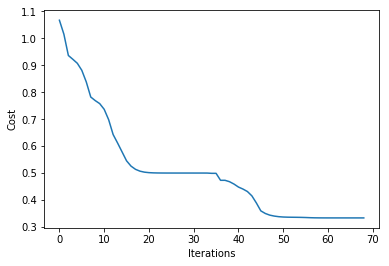

In [63]:
import matplotlib.pyplot as plt
plt.plot(T.J)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()     

## Try building/training a more complex MLP on a bigger dataset.

Use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) to build the cannonical handwriting digit recognizer and see what kind of accuracy you can achieve. 

If you need inspiration, the internet is chalk-full of tutorials, but I want you to see how far you can get on your own first. I've linked to the original MNIST dataset above but it will probably be easier to download data through a neural network library. If you reference outside resources make sure you understand every line of code that you're using from other sources, and share with your fellow students helpful resources that you find.


In [0]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [0]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train = x_train.astype('int')
y_train = y_train.astype('int')
y_test = y_test.astype('int')
x_test = x_test.astype('int')

In [25]:
feature_cols = tf.contrib.learn.infer_real_valued_columns_from_input(x_train)
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[300,100], n_classes=10,
                                         feature_columns=feature_cols)
dnn_clf = tf.contrib.learn.SKCompat(dnn_clf)  # if TensorFlow >= 1.1
dnn_clf.fit(x_train, y_train, batch_size=50, steps=20000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fcaccdf7b70>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmpfjbt633y'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpfjbt633y/mo

SKCompat()

In [26]:
y_pred = dnn_clf.predict(x_test)
accuracy_score(y_test, y_pred['classes'])

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpfjbt633y/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


0.9408

## Stretch Goals: 

- Implement Cross Validation model evaluation on your MNIST implementation 
- Research different [Gradient Descent Based Optimizers](https://keras.io/optimizers/)
 - [Siraj Raval the evolution of gradient descent](https://www.youtube.com/watch?v=nhqo0u1a6fw)
- Build a housing price estimation model using a neural network. How does its accuracy compare with the regression models that we fit earlier on in class?